<a href="https://colab.research.google.com/github/ankygupta9999/DL-image-captioning/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# copy dataset
#!wget --no-check-certificate \
#  https://drive.google.com/file/d/1A8g74ohdb_5d2fPjc72yF7GxufE9GRcu/view?usp=sharing \
#  -O /tmp/set_1.pkl

#!wget --no-check-certificate \
#  https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing \
#  -O /tmp/Image_captioning_Dataset.zip

#!pip install PyDrive

#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# https://drive.google.com/file/d/1uaD3aDq1Xm7jFII6NYhbegtyREC6NAq-/view?usp=sharing
#downloaded = drive.CreateFile({'id':"1uaD3aDq1Xm7jFII6NYhbegtyREC6NAq-"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('set_1.pkl')        # replace the file name with your file

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import pandas as pd
import pickle
import os

FILE_PATH = "/content/gdrive/MyDrive/bits/DL-assignment"
IMAGE_DATA_PATH = "/content/gdrive/MyDrive/bits/DL-assignment/Image_captioning_Dataset.zip"
pickle_name = os.path.join(FILE_PATH, "set_1.pkl")

In [ ]:
# Download the dataset
!unzip IMAGE_DATA_PATH

In [12]:
IMAGE_DATA_FOLDER = "Flicker8k_Dataset/"

In [13]:
# Method 1
objects = pd.read_pickle(pickle_name)
df = pd.DataFrame(objects)
print(type(df))
print(df)

# # Method 2
# pickle_file = open(pickle_name, "rb")
# objects = []

# while True:
#     try:
#         objects.append(pickle.load(pickle_file))
#     except EOFError:
#         break

# pickle_file.close()
# df = pd.DataFrame(objects)
# print(type(df))
# print(df)

<class 'pandas.core.frame.DataFrame'>
                                                       0
0      2089122314_40d5739aef.jpg#3\tA fluffy , tri-co...
1      1295671216_cde1b9c9d1.jpg#0\tA crowd of person...
2      3183195185_cd0ff994a1.jpg#4\tThe man and boy s...
3      2949353587_64c54e9589.jpg#1\tA brown dog be pl...
4      361092202_3d70144ebd.jpg#2\tA man hike with a ...
...                                                  ...
24995  3503623999_bbd5dcfb18.jpg#0\tA man in a crowd ...
24996  542405691_0594b1ce72.jpg#0\tA boy kick a ball ...
24997  1244485675_822e6efe60.jpg#1\tA boy look at his...
24998  475778645_65b7343c47.jpg#4\tA small child clim...
24999  381052465_722e00807b.jpg#4\tPeople put out a f...

[25000 rows x 1 columns]


In [14]:
objects[0]

'2089122314_40d5739aef.jpg#3\tA fluffy , tri-colored dog be run down a road with a paper in its mouth .'

In [15]:
len(objects)

25000

In [16]:
raw_df = pd.DataFrame()
for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  img_dict['caption_id'] = row.split(img_dict['img_nm'])[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)
raw_df.head()

,caption_id,img_caption,img_nm
0,#3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,#0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,#4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,#1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,#2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [17]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   25000 non-null  object
 1   img_caption  25000 non-null  object
 2   img_nm       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [18]:
len(raw_df.img_nm.unique())

8033

In [19]:
len(os.listdir(IMAGE_DATA_FOLDER))

8091

In [30]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [42]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      just_img_nm = img_nm.split(sep='.')[0]
      # print ("printing {} , image :{}".format(i, just_img_nm))
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title(just_img_nm)
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

**Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

============== Printing Sample images ================
printing 0 , image :3224578187_749882c17f
printing 1 , image :3357708906_fb3a54dd78
printing 2 , image :2290330500_e7bdaa58e1
printing 3 , image :2918880895_e61f74f2f0
printing 4 , image :3627216820_4952bacbcb


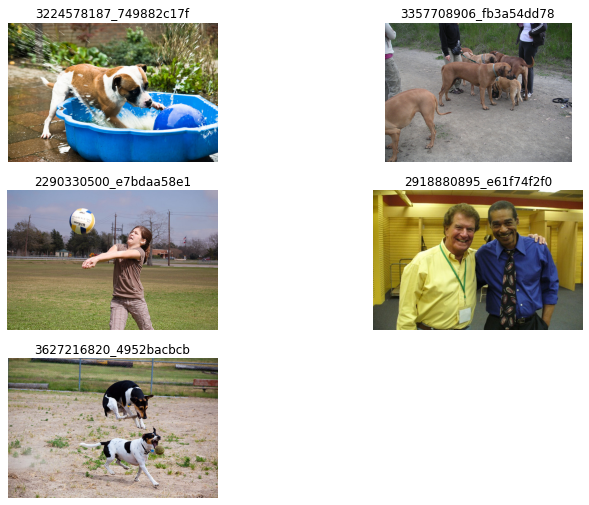

In [46]:
print_sample_imgs(IMAGE_DATA_FOLDER, os.listdir(IMAGE_DATA_FOLDER), 6, 2, 5)